## Case Study on Loss Given Default
#### Context:
CNB Bank deals in all kinds of car loans. Customer first apply for loan after that company validates the customer eligibility 
for loan. In case the borrower doesn’t pay back the loan, the losses are to be incurred by the bank. LGD stands for Loss given 
default so it means when a customer at a bank defaults on his loan how much money does the bak lose. The customer might have 
paidsome amount back or no amount at all.The bank wants to know if the amount the bank loses can be predicted for new customers 
who apply for a loanfrom the past data of all defaulters and their pending amounts

#### Problem:
The bank wants to automate the loss estimation based on customer detail provided while applying for loan. 
These details are Age, Years of Experience, Number of cars, Gender, Marital Status. To automate this process, 
they have given a problem to identify the loss estimation given that the customers is a defaulter, those are eligible 
for loan amount so that they get to know what features are leading to defaults up to which amount. 
Here are the details about the data set.

#### Data:
Variable Description Ac_No The account of customer used as identifier Age Age of borrower (16-70) Years of Experience 
Working experience (0-53) Number of Cars Possessed cars (1, 2, 3, 4) Gender Male/Female Married Married/Single Loss in 
Thousands Target variable

In [136]:
#import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # this is for visualization
import seaborn as sns # for visualization
%matplotlib inline
import statsmodels.formula.api as sm
import scipy, scipy.stats
import math # log function is inside this library
# this is used to get the plots inline i.e. in the same page
from collections import Counter

In [137]:
# read the csv file into a dataframe
df=pd.read_csv("LGD.csv")

In [138]:
# lets do a basic EDA ( exploratory data analysis) on the file
df.info() # this tells us 15290 rows & 7 columns
#df.shape will also give the same info
#df.info also tells us there are no NULL values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15290 entries, 0 to 15289
Data columns (total 7 columns):
Ac_No                  15290 non-null int64
Age                    15290 non-null int64
Years of Experience    15290 non-null int64
Number of Vehicles     15290 non-null int64
Gender                 15290 non-null object
Married                15290 non-null object
Losses in Thousands    15290 non-null float64
dtypes: float64(1), int64(4), object(2)
memory usage: 836.2+ KB


In [4]:
df.head()

,Ac_No,Age,Years of Experience,Number of Vehicles,Gender,Married,Losses in Thousands
0,150024,24,5,1,M,Married,203.319595
1,144880,31,10,1,F,Single,402.197302
2,133742,56,37,1,M,Married,553.132096
3,151282,52,31,1,F,Married,292.430579
4,174407,20,3,1,M,Single,246.540576


In [139]:
df.describe()

,Ac_No,Age,Years of Experience,Number of Vehicles,Losses in Thousands
count,15290.000000,15290.000000,15290.000000,15290.000000,15290.000000
mean,149961.789339,42.328254,23.732897,2.495880,389.859718
std,28947.841061,18.280511,17.850707,0.953776,253.729433
min,100002.000000,16.000000,0.000000,1.000000,12.534521
25%,124900.500000,24.000000,6.000000,2.000000,226.434217
50%,149897.500000,42.000000,23.000000,2.000000,354.937874
75%,175019.500000,61.000000,42.000000,3.000000,488.676927
max,200454.000000,70.000000,53.000000,4.000000,3500.000000


In [140]:
df.Gender.unique()

array(['M', 'F'], dtype=object)

In [141]:
df.Married.unique()

array(['Married', 'Single'], dtype=object)

In [143]:
np.where(pd.isna(df['Ac_No']))

(array([], dtype=int64),)

In [144]:
df[['Age', 'Years of Experience', 'Number of Vehicles', 'Losses in Thousands']].corr()
# we see a high co-relation between Age and Years of Experience 
# which is obvious as with Age your Experience increases

,Age,Years of Experience,Number of Vehicles,Losses in Thousands
Age,1.000000,0.997161,0.008366,-0.442962
Years of Experience,0.997161,1.000000,0.008545,-0.442115
Number of Vehicles,0.008366,0.008545,1.000000,-0.011553
Losses in Thousands,-0.442962,-0.442115,-0.011553,1.000000


In [145]:
import seaborn as sns

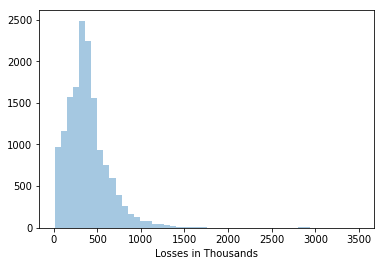

In [13]:
sns.distplot(df['Losses in Thousands'], kde=False, bins=50)

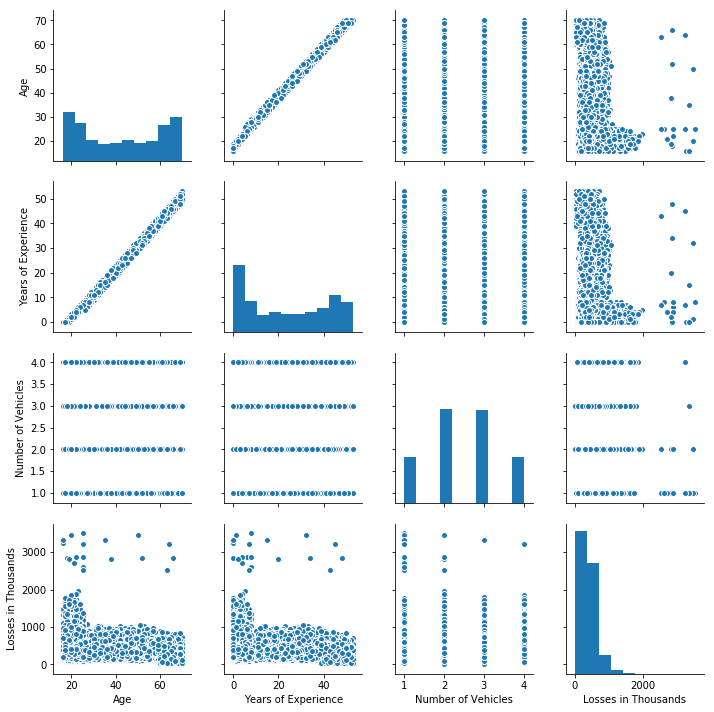

In [14]:
sns.pairplot(df[['Age', 'Years of Experience', 'Number of Vehicles', 'Losses in Thousands']])

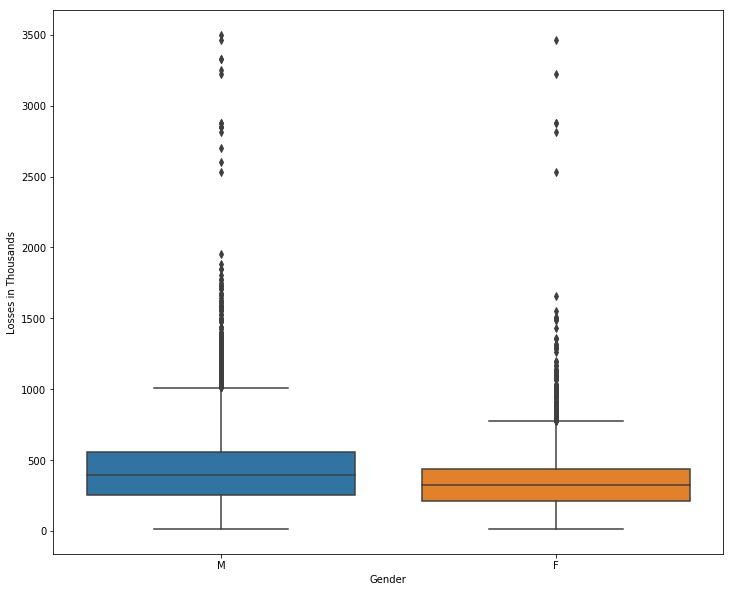

In [16]:
plt.figure(figsize=(12,10))
sns.boxplot(df['Gender'], df['Losses in Thousands'])

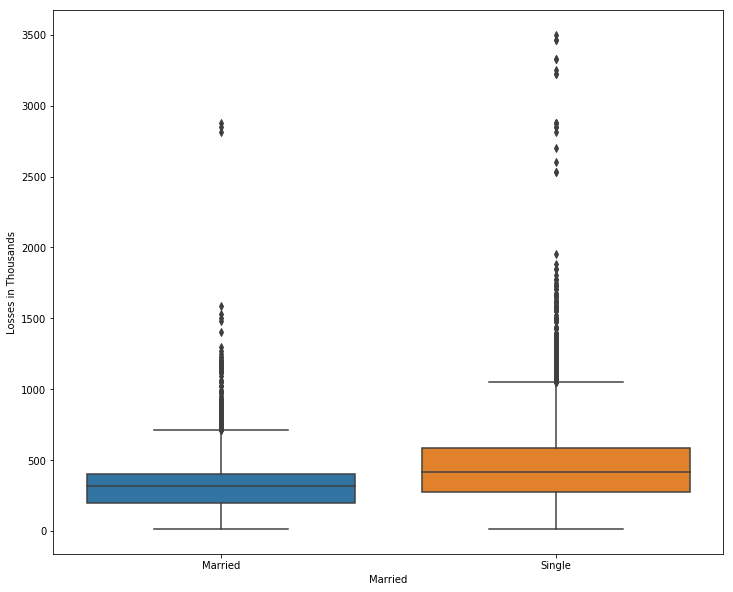

In [17]:
plt.figure(figsize=(12,10))
sns.boxplot(df['Married'], df['Losses in Thousands'])

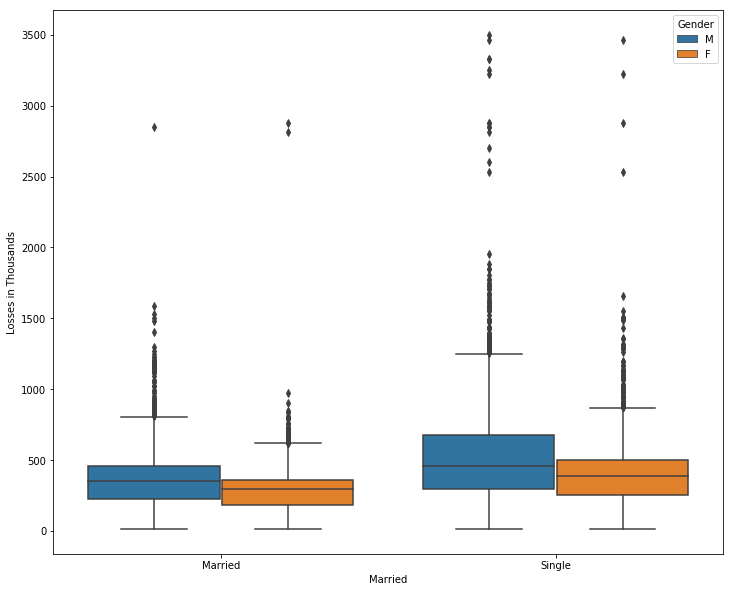

In [19]:
plt.figure(figsize=(12,10))
sns.boxplot(df['Married'], df['Losses in Thousands'], hue=df['Gender'])

In [148]:
# first lets build a simple model with all variables and as is
# we will have to convert the string variables to dummy variables 
dummy_var1=pd.get_dummies(df['Gender'],drop_first=True)
#simillarly for married
dummy_var2=pd.get_dummies(df['Married'],drop_first=True)
dummy_var2.head()
# merge the above 2 dataframe with the original dataframe df
df_new=pd.concat([df,dummy_var1,dummy_var2],axis=1)
df_new.head()

,Ac_No,Age,Years of Experience,Number of Vehicles,Gender,Married,Losses in Thousands,M,Single
0,150024,24,5,1,M,Married,203.319595,1,0
1,144880,31,10,1,F,Single,402.197302,0,1
2,133742,56,37,1,M,Married,553.132096,1,0
3,151282,52,31,1,F,Married,292.430579,0,0
4,174407,20,3,1,M,Single,246.540576,1,1


In [151]:
#decide your regressor and predictor variables
x=df_new[["Age","Number of Vehicles","M","Single"]]
y=df_new["Losses in Thousands"]

In [150]:
#split the data into train and test
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

In [152]:
from statsmodels.api import add_constant
X2 = add_constant(x_train)

In [154]:
#so the linear regression equation we get is
#----loss in thousands=539.65-6.14*Age-1.79*Number of Vehicles+97*M+136*Single
#so according to above--
#Young people (- coeff)and Male(+ coeff) & Unmarried person(+coeff)
#dont pay their loans back
#lets get the P values of each predictors 
lm= sm.OLS(y_train,X2)

In [155]:
lm2=lm.fit()

In [156]:
lm2.params

const                 539.656523
Age                    -6.149007
Number of Vehicles     -1.790592
M                      97.234933
Single                136.792250
dtype: float64

In [157]:
lm2.pvalues
# sm.OLS by default does not add an intercept in the model.
#so we manually added it by the first line

const                  0.000000e+00
Age                    0.000000e+00
Number of Vehicles     4.052234e-01
M                     1.470589e-121
Single                6.953054e-233
dtype: float64

In [ ]:
#### Adjusted R Square and Degrees of Freedom

https://stats.stackexchange.com/questions/277009/why-are-the-degrees-of-freedom-for-multiple-regression-n-k-1-for-linear-reg

https://people.richland.edu/james/ictcm/2004/multiple.html

In [158]:
#to see the summary
print(lm2.summary())

                             OLS Regression Results                            
Dep. Variable:     Losses in Thousands   R-squared:                       0.305
Model:                             OLS   Adj. R-squared:                  0.304
Method:                  Least Squares   F-statistic:                     1171.
Date:                 Tue, 25 Dec 2018   Prob (F-statistic):               0.00
Time:                         12:25:30   Log-Likelihood:                -72503.
No. Observations:                10703   AIC:                         1.450e+05
Df Residuals:                    10698   BIC:                         1.451e+05
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                539.6

In [159]:
X2_test = add_constant(x_test)

In [162]:
y_test_predict = lm2.predict(X2_test)

In [163]:
from matplotlib import pyplot as plt

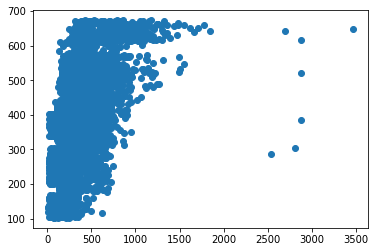

In [164]:
plt.scatter(list(y_test), list(y_test_predict))
plt.show()

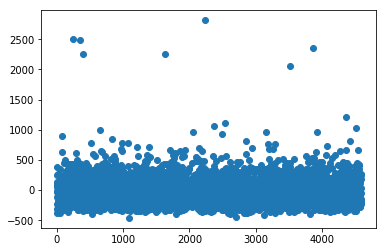

In [165]:
plt.scatter(range(len(y_test)), (np.array(y_test) - np.array(y_test_predict)))
plt.show()

In [166]:
from sklearn.metrics import r2_score
r2_score(y_test, y_test_predict)

0.29505257544943986

In [167]:
from sklearn import metrics

In [168]:
print(metrics.mean_absolute_error(y_test,y_test_predict))

148.50819212153783


In [169]:
print(metrics.mean_squared_error(y_test,y_test_predict))

45262.36761675595


In [173]:
X2 = X2.drop('Number of Vehicles', axis=1)

In [174]:
#lets get the P values of each predictors 
lm= sm.OLS(y_train,X2)
lm2=lm.fit()

In [175]:
lm2.params

const     535.221707
Age        -6.149477
M          97.224869
Single    136.766200
dtype: float64

In [176]:
X2_test = X2_test.drop('Number of Vehicles', axis=1)

In [177]:
y_test_predict = lm2.predict(X2_test)

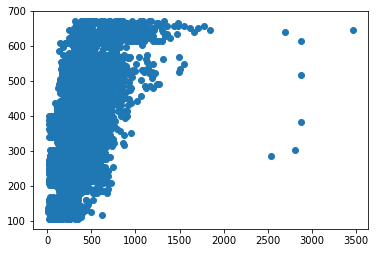

In [178]:
plt.scatter(list(y_test), list(y_test_predict))
plt.show()

In [179]:
print(metrics.mean_absolute_error(y_test,y_test_predict))

148.51326576030235


http://statisticsbyjim.com/regression/guide-stepwise-best-subsets-regression/

https://people.duke.edu/~rnau/regstep.htm

In [ ]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [180]:
from sklearn.linear_model import LinearRegression # import the functions
lm=LinearRegression() #call the function
lm.fit(x_train,y_train)# fit the model

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [181]:
lm.intercept_

539.6565230110673

In [182]:
lm.coef_

array([ -6.14900704,  -1.79059246,  97.23493268, 136.7922503 ])

In [183]:
#split the data into train and test
from sklearn.cross_validation import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=1)

In [184]:
x_train = x_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

In [185]:
x_test = x_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [186]:
x_train['M_Single'] = x_train[['M','Single']].apply(lambda x: x[0]*x[1], axis=1)

In [187]:
x_test['M_Single'] = x_test[['M','Single']].apply(lambda x: x[0]*x[1], axis=1)

In [188]:
from sklearn.preprocessing import PolynomialFeatures

In [189]:
poly = PolynomialFeatures(2, include_bias=False)

In [190]:
x_poly = poly.fit_transform(x_train[['Age', 'Number of Vehicles']].values)

In [191]:
x_poly

array([[6.800e+01, 4.000e+00, 4.624e+03, 2.720e+02, 1.600e+01],
       [4.900e+01, 3.000e+00, 2.401e+03, 1.470e+02, 9.000e+00],
       [4.500e+01, 3.000e+00, 2.025e+03, 1.350e+02, 9.000e+00],
       ...,
       [6.000e+01, 3.000e+00, 3.600e+03, 1.800e+02, 9.000e+00],
       [2.700e+01, 1.000e+00, 7.290e+02, 2.700e+01, 1.000e+00],
       [7.000e+01, 4.000e+00, 4.900e+03, 2.800e+02, 1.600e+01]])

In [192]:
x_poly_df = pd.DataFrame(x_poly, columns=['Age', 'Number of Vehicles', 'Age_2', 'Age_Veh', 'Veh_2'])

In [193]:
x_train = pd.concat([x_poly_df, x_train[['M', 'Single', 'M_Single']]], axis=1)

In [194]:
x_train.head()

,Age,Number of Vehicles,Age_2,Age_Veh,Veh_2,M,Single,M_Single
0,68.0,4.0,4624.0,272.0,16.0,1,0,0
1,49.0,3.0,2401.0,147.0,9.0,0,0,0
2,45.0,3.0,2025.0,135.0,9.0,0,1,0
3,19.0,3.0,361.0,57.0,9.0,1,1,1
4,36.0,2.0,1296.0,72.0,4.0,0,0,0


In [195]:
lm_inter = LinearRegression()

In [196]:
lm_inter.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [197]:
lm_inter.coef_

array([ 6.53390752e-01,  1.90772420e+00, -7.89669895e-02, -1.29017371e-02,
       -5.70084625e-01,  7.10342722e+01,  1.10343589e+02,  5.39799371e+01])

In [198]:
x_poly = poly.fit_transform(x_test[['Age', 'Number of Vehicles']].values)

In [199]:
x_poly_df = pd.DataFrame(x_poly, columns=['Age', 'Number of Vehicles', 'Age_2', 'Age_Veh', 'Veh_2'])

In [200]:
x_test = pd.concat([x_poly_df, x_test[['M', 'Single', 'M_Single']]], axis=1)

In [201]:
y_test_predict_lm_inter = lm_inter.predict(x_test)

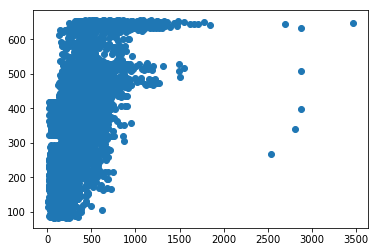

In [203]:
plt.scatter(np.array(y_test), np.array(y_test_predict_lm_inter))
plt.show()

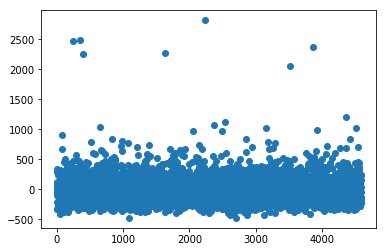

In [202]:
plt.scatter(range(len(y_test)), (np.array(y_test) - np.array(y_test_predict_lm_inter)))
plt.show()

In [204]:
print(metrics.mean_absolute_error(y_test,y_test_predict_lm_inter))

146.51855802601946


### Regularization Linear Regression - Lasso and Ridge

https://towardsdatascience.com/regularization-in-machine-learning-76441ddcf99a
    
https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/

In [205]:
from sklearn.linear_model import Ridge

In [206]:
ridge_lm = Ridge(alpha=4)

In [207]:
ridge_lm.fit(x_train, y_train)

Ridge(alpha=4, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [209]:
lm_inter.coef_

array([ 6.53390752e-01,  1.90772420e+00, -7.89669895e-02, -1.29017371e-02,
       -5.70084625e-01,  7.10342722e+01,  1.10343589e+02,  5.39799371e+01])

In [208]:
ridge_lm.coef_

array([ 6.52941762e-01,  1.87630753e+00, -7.89636421e-02, -1.28239578e-02,
       -5.64432019e-01,  7.08262042e+01,  1.10076437e+02,  5.41880128e+01])

In [210]:
y_test_predict_ridge_inter = ridge_lm.predict(x_test)

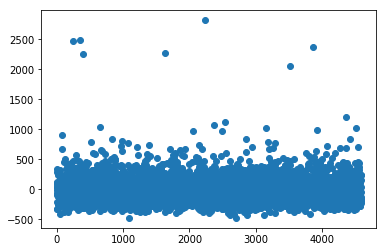

In [211]:
plt.scatter(range(len(y_test)), (np.array(y_test) - np.array(y_test_predict_ridge_inter)))
plt.show()

In [212]:
print(metrics.mean_absolute_error(y_test,y_test_predict_ridge_inter))

146.5148627523706


In [213]:
from sklearn.linear_model import Lasso

In [214]:
lm_lasso = Lasso(alpha=4)

In [215]:
lm_lasso.fit(x_train, y_train)

Lasso(alpha=4, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [220]:
lm_inter.coef_

array([ 6.53390752e-01,  1.90772420e+00, -7.89669895e-02, -1.29017371e-02,
       -5.70084625e-01,  7.10342722e+01,  1.10343589e+02,  5.39799371e+01])

In [216]:
lm_lasso.coef_

array([ 9.44625007e-02, -0.00000000e+00, -7.22385088e-02, -2.39631376e-02,
       -0.00000000e+00,  5.55308812e+01,  9.48432619e+01,  5.28996651e+01])

In [218]:
y_test_predict_lasso_inter = lm_lasso.predict(x_test)

In [219]:
print(metrics.mean_absolute_error(y_test,y_test_predict_lasso_inter))

146.27739232289977
